# Generating QB Questions
Phillip Guo

In this HW I'll be loading Meta's new LLaMA 3 8B Instruct model and training it with lora to generate quizbowl questions, given an answer (first). I will fine tune it on a particular chat format, taking in the system prompt, an answer, then a question (in inference, I'll provide the answer). I also trained a Llama 2 7B Chat lora to do the same.

Memory requirements: for training, depends on learning rate. I rented an 80GB GPU from Vast.ai to have batch size 16.
For inference, only require 24GB GPU. I uploaded the saved PEFTs in the github, in meta-llama/Meta-Llama-3-8B-Instruct-qa-lora and meta-llama/Llama-2-7b-chat-hf

## Load LLaMA-3

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import transformers
import datasets
import torch
import pandas as pd
from tqdm.auto import tqdm
import pickle
import einops
import os
from datetime import datetime
import transformers

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM, LlamaTokenizer
from peft import PeftModel
# model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
model_name = "meta-llama/Llama-2-7b-chat-hf"
model =LlamaForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = LlamaForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf", torch_dtype=torch.bfloat16, device_map='auto')
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
tokenizer.pad_token = tokenizer.eos_token
# tokenizer.add_special_tokens(
#     {

#         "pad_token": "<PAD>",
#     }
# )


Loading checkpoint shards: 100%|██████████| 2/2 [00:20<00:00, 10.31s/it]


## Load Dataset

In [3]:
# open qanta.buzztrain.json
import json

with open('qanta.buzztrain.json', 'r') as f:
    data = json.load(f)

print(len(data))
print(data[0].keys())
print(data[0])

train_data = data[:int(len(data)*.8)]
test_data = data[int(len(data)*.8):int(len(data)*.9)]
gen_data = data[int(len(data)*.9):]

train_data = train_data[:5000]

18460
dict_keys(['text', 'answer', 'page', 'category', 'subcategory', 'tournament', 'difficulty', 'year', 'proto_id', 'qdb_id', 'dataset', 'qanta_id', 'tokenizations', 'first_sentence', 'answer_prompt', 'gameplay', 'fold'])
{'text': 'After this character relates a story about how he didn\'t know the proper way to use a wheelbarrow, he tells of how a captain dining with his father mistakenly rubbed his hands in a punch bowl.\xa0This "sea Prince of Wales" leaves his home by hiding out in a canoe near a coral reef, and he is mistakenly called "Hedgehog" by a character who offers him a ninetieth lay, a partner of Bildad named Peleg. A door is broken down in Mrs. Hussey\'s establishment after he locks himself in his room during a "Ramadan."\xa0He is first encountered in the Spouter-Inn where the landlord thinks he may be late because "he can\'t sell his head," and his coffin helps save the narrator after the ship he\'s on sinks.\xa0For 10 points, name this native of Rokovoko and savage comp

In [4]:
trivia_system_message = {"role": "system", "content": """You are a helpful assistant generating trivia questions. I will provide an answer, and you must generate a quizbowl question that gives clues about the answer starting with hard and ending with easy questions."""}
from datasets import Dataset

max_length = 512
# Assuming 'data' is your list of dictionaries
train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))
test_dataset = Dataset.from_pandas(pd.DataFrame(test_data))
gen_dataset = Dataset.from_pandas(pd.DataFrame(gen_data))
def preprocess_llama_dataset_for_hf(example, include_question=True, sys_msg=trivia_system_message, tokenizer=tokenizer):
    # make a dialogue
    answer_msg = {"role": "user", "content": f"Answer: {example['answer']}"}
    dialogue = [sys_msg, answer_msg]
    
    if include_question:
        question_msg = {"role": "assistant", "content": f"Question:\n{example['text']}"}
        dialogue.append(question_msg)
        # chat = tokenizer.apply_chat_template(dialogue, truncation=True, padding=True, max_length=512)
        chat = tokenizer.apply_chat_template(dialogue)
    else:
        question_msg = {"role": "assistant", "content": "Question:\n"}
        dialogue.append(question_msg)
        chat = tokenizer.apply_chat_template(dialogue)[:-1]

    # Return the necessary fields
    return {
        "input_ids": chat,
        "formatted_prompt": tokenizer.decode(chat),
        "labels": chat,
    }

# Apply the preprocessing function to each item in the dataset
train_dataset = train_dataset.map(preprocess_llama_dataset_for_hf, batched=False)
test_dataset = test_dataset.map(preprocess_llama_dataset_for_hf, batched=False)
gen_dataset = gen_dataset.map(lambda example: preprocess_llama_dataset_for_hf(example, include_question=False), batched=False)


Map: 100%|██████████| 1846/1846 [00:01<00:00, 1206.18 examples/s]


### Sample Generation

In [5]:
# test generation
print(tokenizer.decode(train_dataset[0]['input_ids']))
# print(len(train_dataset[1]['input_ids']))
sample_input = torch.tensor(gen_dataset[0]['input_ids'], device="cuda").unsqueeze(0)
# print(tokenizer.decode(sample_input))
generation = model.generate(sample_input, max_new_tokens=100)
print(tokenizer.batch_decode(generation)[0])

<s> [INST] <<SYS>>
You are a helpful assistant generating trivia questions. I will provide an answer, and you must generate a quizbowl question that gives clues about the answer starting with hard and ending with easy questions.
<</SYS>>

Answer: Queequeg [/INST] Question:
After this character relates a story about how he didn't know the proper way to use a wheelbarrow, he tells of how a captain dining with his father mistakenly rubbed his hands in a punch bowl. This "sea Prince of Wales" leaves his home by hiding out in a canoe near a coral reef, and he is mistakenly called "Hedgehog" by a character who offers him a ninetieth lay, a partner of Bildad named Peleg. A door is broken down in Mrs. Hussey's establishment after he locks himself in his room during a "Ramadan." He is first encountered in the Spouter-Inn where the landlord thinks he may be late because "he can't sell his head," and his coffin helps save the narrator after the ship he's on sinks. For 10 points, name this native 

## train a rank-16 LoRA

Parts are taken from https://github.com/meta-llama/llama-recipes/blob/main/recipes/finetuning/huggingface_trainer/peft_finetuning.ipynb

In [6]:
from peft import get_peft_model
from peft import LoraConfig, TaskType

model.train()

def create_peft_config(model):
    from peft import (
        get_peft_model,
        LoraConfig,
        TaskType,
    )

    peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        inference_mode=False,
        r=16,
        lora_alpha=32,
        lora_dropout=0.05,
        target_modules = ["q_proj", "v_proj"]
    )

    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()
    return model, peft_config

# create peft config
model, lora_config = create_peft_config(model)
model.cuda()

trainable params: 8,388,608 || all params: 6,746,804,224 || trainable%: 0.12433454005023165


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
      

## Couldn't get huggingface trainer to work so writing my own train loop

In [7]:
from torch.nn.utils.rnn import pad_sequence

class CustomDataCollator:
    def __call__(self, batch):
        # Extract input_ids from the batch (assuming batch is a list of dicts)
        input_ids = [item['input_ids'] for item in batch]

        # Convert input_ids into a list of tensors
        input_ids_tensors = [torch.tensor(ids) for ids in input_ids]

        # Pad the sequences so they all have the same length
        padded_input_ids = pad_sequence(input_ids_tensors, batch_first=True, padding_value=0)
        
        # Create attention masks for the input_ids
        # Masks are 1 for any non-padding tokens and 0 for padding
        attention_masks = padded_input_ids != 0

        # You can return a dictionary with the masks and the padded input ids
        return {
            'input_ids': padded_input_ids,
            'attention_mask': attention_masks
        }
from torch.utils.data import DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=CustomDataCollator())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=CustomDataCollator())

train_iter = iter(train_loader)
test_iter = iter(test_loader)

In [8]:
# FUCK THIS INDEXING IT WAS SO ANNOYING

num_steps = 50  # Set the number of training steps
current_step = 0

grad_accum_steps = 4
device="cuda"
model.train()  # Set the model to training mode

trainable_params = []
for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_params.append(param)
from torch.optim import AdamW
optimizer = AdamW(trainable_params, lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(reduce=True)

train_losses = []
test_losses = []
for current_step in tqdm(range(num_steps)):
    optimizer.zero_grad()  # Clear previous gradients

    tot_loss = 0
    for i in range(grad_accum_steps):
        batch = next(train_iter)
        
        # Move batch to the same device as the model
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Prepare targets: for predicting the next token, shift input_ids to the left
        labels = input_ids[:, 1:][attention_mask[:, 1:]].contiguous()

        model_output = model(input_ids[:, :-1].contiguous(), attention_mask=attention_mask[:, :-1].contiguous())
        logits = model_output.logits[attention_mask[:, 1:].contiguous()]
        # print(f"input_ids shape: {input_ids.shape}, {logits.shape=}, {labels.shape=}")

        loss = criterion(logits, labels)
        # if loss is nan ignore
        if torch.isnan(loss):
            print("Loss is nan, skipping")
            continue
        # print(loss)
        tot_loss += loss.item()

        # Backward pass and optimizer step
        loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    train_losses.append(tot_loss / grad_accum_steps)
    # Optionally print the loss
    if current_step % 10 == 0 or current_step == num_steps - 1:
        # eval on test
        with torch.no_grad():
            model.eval()
            test_loss = 0
            for i in range(grad_accum_steps):
                batch = next(test_iter)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = input_ids[:, 1:][attention_mask[:, 1:]].contiguous()
                model_output = model(input_ids[:, :-1].contiguous(), attention_mask=attention_mask[:, :-1].contiguous())
                logits = model_output.logits[attention_mask[:, 1:].contiguous()]
                loss = criterion(logits, labels)
                test_loss += loss.item()
        model.train()
        print(f"Step {current_step}, Train Loss: {tot_loss / grad_accum_steps}, Test Loss: {test_loss / grad_accum_steps}")
        test_losses.append(test_loss / grad_accum_steps)

print("Training complete.")
model.save_pretrained(model_name+"-qa-lora")

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:05<04:19,  5.29s/it]

Step 0, Train Loss: 3.7007407546043396, Test Loss: 3.6590341329574585


 22%|██▏       | 11/50 [00:41<02:33,  3.94s/it]

Step 10, Train Loss: 2.5925450921058655, Test Loss: 2.628168046474457


 42%|████▏     | 21/50 [01:18<02:00,  4.16s/it]

Step 20, Train Loss: 2.082644760608673, Test Loss: 2.0860084891319275


 62%|██████▏   | 31/50 [01:54<01:16,  4.01s/it]

Step 30, Train Loss: 1.763522058725357, Test Loss: 1.7754258215427399


 82%|████████▏ | 41/50 [02:31<00:35,  3.98s/it]

Step 40, Train Loss: 1.660987913608551, Test Loss: 1.655565232038498


100%|██████████| 50/50 [03:04<00:00,  3.69s/it]

Step 49, Train Loss: 1.558701992034912, Test Loss: 1.6785098910331726
Training complete.


## Plot Train and Test Loss
Cross entropy on train and test questions (technically shouldn't really be a difference since I don't do multiple epochs)

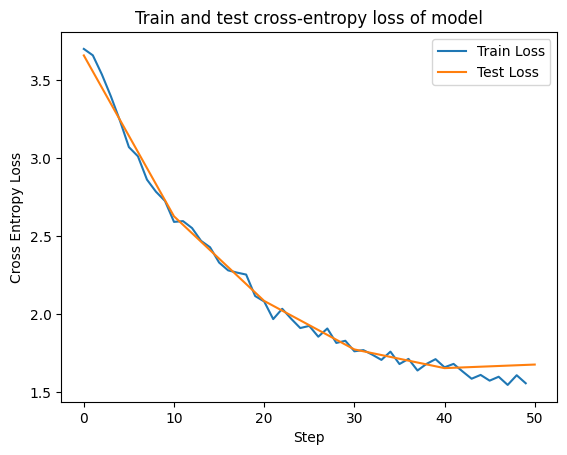

In [9]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_losses)), train_losses, label="Train Loss")
plt.plot(range(0, len(test_losses)*10, 10), test_losses, label="Test Loss")
plt.xlabel("Step")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.title("Train and test cross-entropy loss of model")
plt.show()

## Sample new questions
If you want to run this cell, only need 24GB, only run first cell in notebook (main imports).

In [2]:
# can load either llama-2-7b-qa-lora or llama-3-8b-qa-lora
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM, LlamaTokenizer
from peft import PeftModel

model_name = "meta-llama/Llama-2-7b-chat-hf" # or "meta-llama/Meta-Llama-3-8B-Instruct"

base_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
model = PeftModel.from_pretrained(base_model, model_name+"-qa-lora")
model.cuda()

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


In [3]:
import json

with open('qanta.buzztrain.json', 'r') as f:
    data = json.load(f)

print(len(data))
print(data[0].keys())
print(data[0])

train_data = data[:int(len(data)*.8)]
test_data = data[int(len(data)*.8):int(len(data)*.9)]
gen_data = data[int(len(data)*.9):]
trivia_system_message = {"role": "system", "content": """You are a helpful assistant generating trivia questions. I will provide an answer, and you must generate a quizbowl question that gives clues about the answer starting with hard and ending with easy questions."""}
from datasets import Dataset

max_length = 512

def sample_question(answer, sys_msg=trivia_system_message, tokenizer=tokenizer, max_new_tokens=100):
    answer_msg = {"role": "user", "content": f"Answer: {answer}"}
    dialogue = [sys_msg, answer_msg]
    
    question_msg = {"role": "assistant", "content": "Question:\n"}
    dialogue.append(question_msg)
    chat = tokenizer.apply_chat_template(dialogue)[:-1]

    sample_input = torch.tensor(chat, device="cuda").unsqueeze(0)
    with torch.no_grad():
        generation = model.generate(sample_input, max_new_tokens=max_new_tokens)
    question_alone = generation[0][len(chat)+1:-1]
    return tokenizer.decode(question_alone)

for i in range(3):
    answer = gen_data[i]['answer']
    print(f"Answer: {answer}\nReal Question: {gen_data[i]['text']}\nGenerated question: {sample_question(answer)}")
    print("\n\n")



18460
dict_keys(['text', 'answer', 'page', 'category', 'subcategory', 'tournament', 'difficulty', 'year', 'proto_id', 'qdb_id', 'dataset', 'qanta_id', 'tokenizations', 'first_sentence', 'answer_prompt', 'gameplay', 'fold'])
{'text': 'After this character relates a story about how he didn\'t know the proper way to use a wheelbarrow, he tells of how a captain dining with his father mistakenly rubbed his hands in a punch bowl.\xa0This "sea Prince of Wales" leaves his home by hiding out in a canoe near a coral reef, and he is mistakenly called "Hedgehog" by a character who offers him a ninetieth lay, a partner of Bildad named Peleg. A door is broken down in Mrs. Hussey\'s establishment after he locks himself in his room during a "Ramadan."\xa0He is first encountered in the Spouter-Inn where the landlord thinks he may be late because "he can\'t sell his head," and his coffin helps save the narrator after the ship he\'s on sinks.\xa0For 10 points, name this native of Rokovoko and savage comp